In [1]:
import daisy
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import funlib.segment
import malis
import matplotlib.gridspec as gridspec
import waterz
import logging
from importlib import reload
import utils
reload(utils)


logging.basicConfig(level=logging.INFO)


aff_file = 'affinities_big.zarr'
affs_ds = daisy.open_ds(aff_file, 'volumes/affs')
raw_ds = daisy.open_ds(aff_file, 'volumes/raw')

gt_file = '../data/sample_0.n5'


gtds = daisy.open_ds(gt_file, 'volumes/labels/neuron_ids')
intersectionroi = affs_ds.roi.intersect(gtds.roi)

gt = gtds.to_ndarray(intersectionroi)
raw = raw_ds.to_ndarray(intersectionroi)
affs = affs_ds.to_ndarray(intersectionroi)


In [2]:
bb_begin = (0, 0, 0)
bb_end = (30, 400, 400)

aff_crop = affs[:, bb_begin[0]:bb_end[0],  bb_begin[1]:bb_end[1],  bb_begin[2]:bb_end[2]]
raw_crop = raw[bb_begin[0]:bb_end[0],  bb_begin[1]:bb_end[1],  bb_begin[2]:bb_end[2]]
gt_crop = gt[bb_begin[0]:bb_end[0],  bb_begin[1]:bb_end[1],  bb_begin[2]:bb_end[2]]


z_section = 9

In [3]:
print(gt.shape)
print(raw.shape)
print(intersectionroi)
print(affs.shape)

(62, 561, 761)
(62, 561, 761)
[4000:6480, 6400:8644, 5600:8644] (2480, 2244, 3044)
(3, 62, 561, 761)


Text(0.5, 1.0, 'Raw')

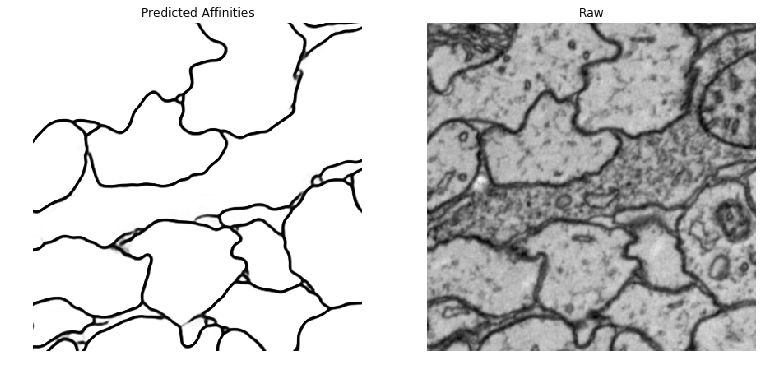

In [4]:

mean_affs = 0.5*(aff_crop[1] + aff_crop[2])



plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(np.squeeze(mean_affs[z_section, :, :]), cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Predicted Affinities')

ax = plt.subplot(gs[0,1])
ax.imshow(raw_crop[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Raw')

## Obtain a segmentation by thresholding
Given a perfect boundary prediction, obtaining a segmentation would be trivial. It would be enough to create a binary mask by thresholding and then finding connected component. As we will see, minor errors in our boundary predictions can lead to catastropical errors in our segmentation
### 2D example

In [5]:

threshold = 0.5
mean_affs = 0.5*(aff_crop[1] + aff_crop[2])
boundary = mean_affs[z_section, :] > threshold

cc, num_labels = ndimage.label(boundary)
print(num_labels)

42


Text(0.5, 1.0, 'ConnectedComponents')

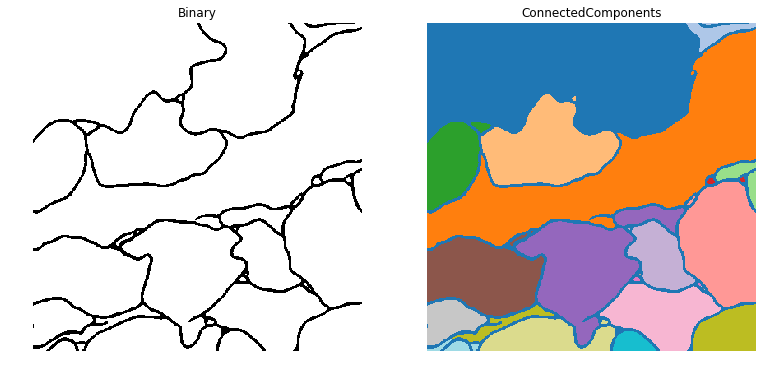

In [6]:

plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
ax.imshow(boundary, cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Binary')

ax = plt.subplot(gs[0,1])
ax.imshow(cc, cmap='tab20')
ax.axis('off')  # clear x- and y-axes
plt.title('ConnectedComponents')

### 3D example
If we do the same procedure in 3D, the effect observed in 2D even gets worse.


Text(0.5, 1.0, 'Connected Component from Affinity Graph')

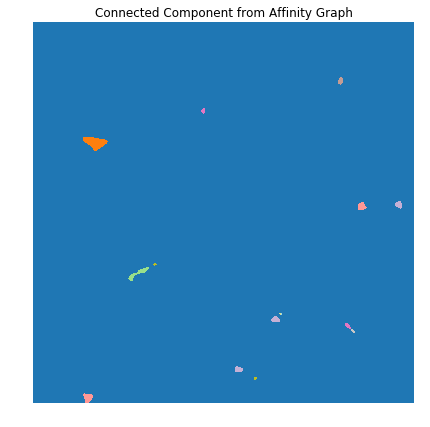

In [7]:
nhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1]]
cc_3d,ccSizes2 = malis.connected_components_affgraph(np.array(aff_crop > threshold, dtype=np.int32),np.array(nhood))
fig, ax = plt.subplots(figsize=(7,7))

im = ax.imshow(cc_3d[z_section, :], cmap='tab20')
ax.axis('off')  # clear x- and y-axes
plt.title('Connected Component from Affinity Graph')

## Use Watershed and Fragment Agglomeration for a more robust segmentation

INFO:utils:Number of fragments in volume: 3742


Text(0.5, 1.0, 'Raw')

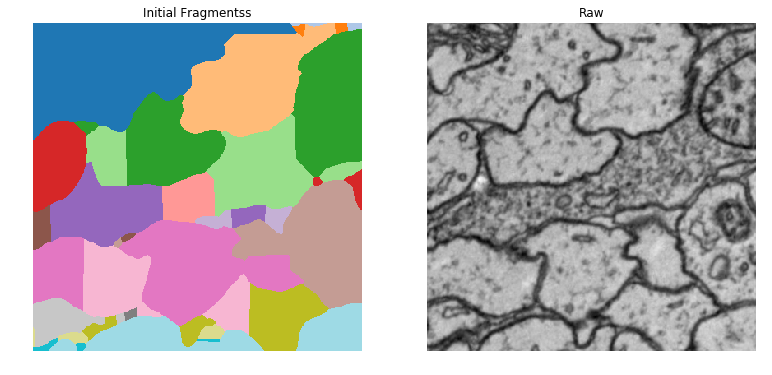

In [8]:

fragments = utils.apply_watershed(aff_crop, fragments_in_xy=True)

plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(fragments[z_section, :], cmap='tab20')
ax.axis('off')  # clear x- and y-axes
plt.title('Initial Fragmentss')

ax = plt.subplot(gs[0,1])
ax.imshow(raw_crop[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Raw')

The watershed is good to prevent too much merging. However, we can clearly see, that now the neurons are broken into too many pieces. In the next step, we will see, how we can agglomerate those little pieces / fragments into larger ones.

# Agglomeration parameters
- scoring_function='OneMinus<MeanAffinity<RegionGraphType, ScoreValue>>' # what are possible scoring functions ?
- what kind of initial fragments
- agglomeration threshold


In [9]:
scorefunction = 'OneMinus<HistogramQuantileAffinity<RegionGraphType, 25, ScoreValue, 256>>'
segments = utils.agglomerate_fragments(aff_crop, fragments, 0.005, 
                                       scoring_function=scorefunction)

Re-using already compiled waterz version
Creating memory-contiguous affinity arrray (avoid this by passing C_CONTIGUOUS arrays)
Preparing segmentation volume...


INFO:utils:Number of segments in volume: 1383


Text(0.5, 1.0, 'Raw')

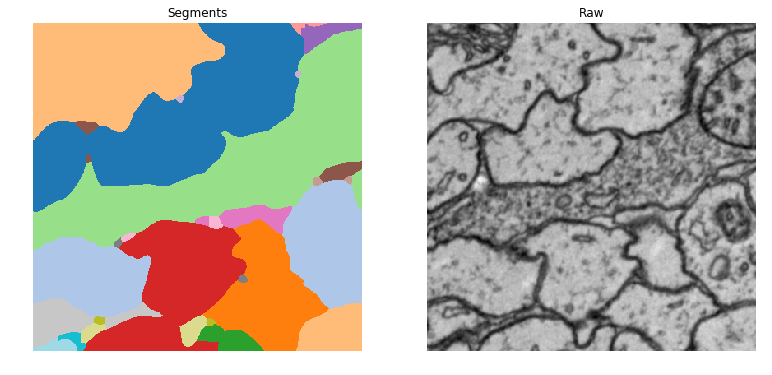

In [10]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])

segsection, label = funlib.segment.arrays.relabel(segments[z_section, :], inplace=False)
plt.imshow(np.array(segsection, dtype=np.float32), cmap='tab20')
ax.axis('off')  # clear x- and y-axes
plt.title('Segments')

ax = plt.subplot(gs[0,1])
ax.imshow(raw_crop[z_section, :], cmap='gray')
ax.axis('off')  # clear x- and y-axes
plt.title('Raw')


### Evaluation

Text(0.5, 1.0, 'Ground Truth')

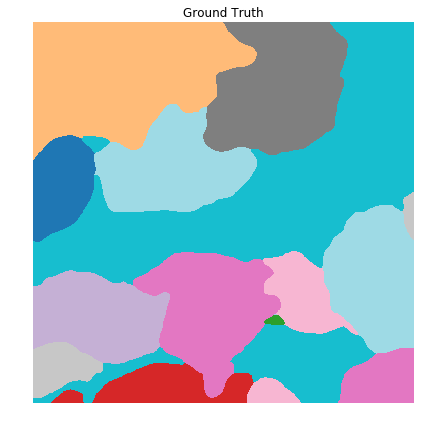

In [11]:
funlib.segment.arrays.relabel(gt_crop, inplace=True)
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(np.squeeze(gt_crop[z_section, :]), cmap='tab20')
ax.axis('off')  # clear x- and y-axes
plt.title('Ground Truth')

In [12]:
res = waterz.evaluate(gt_crop, segments)
print(res)

Creating memory-contiguous segmentation arrray (avoid this by passing C_CONTIGUOUS arrays)
{'voi_split': 0.0632793173322117, 'voi_merge': 1.5976000679244913, 'rand_split': 0.9901279743631802, 'rand_merge': 0.5242457279693981}


(-0.5, 399.5, 399.5, -0.5)

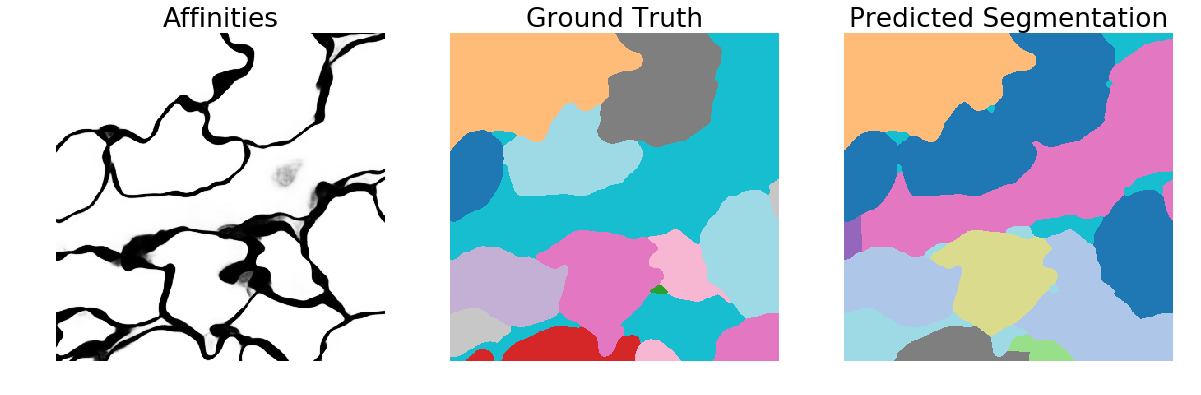

In [14]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0,0])
plt.imshow(np.squeeze(aff_crop[0, z_section, :]), cmap='gray')
ax.set_title('Affinities')
ax.axis('off') 
ax = plt.subplot(gs[0,1])
ax.imshow(np.squeeze(gt_crop[z_section, :]), cmap='tab20')
ax.set_title('Ground Truth')
ax.axis('off') 
ax = plt.subplot(gs[0,2])
ax.imshow(segments[z_section, :], cmap='tab20')
ax.set_title('Predicted Segmentation')
ax.axis('off') 